First we load the images and find the rectangles in each image with which we want to do perspective change.

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [28]:
DARK_READER = True
if DARK_READER:
    plt.rcParams.update({
        "lines.color": "white",
        "patch.edgecolor": "white",
        "text.color": "black",
        "axes.facecolor": "white",
        "axes.edgecolor": "lightgray",
        "axes.labelcolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "grid.color": "lightgray",
        "figure.facecolor": "black",
        "figure.edgecolor": "black",
        "savefig.facecolor": "black",
        "savefig.edgecolor": "black",
    })

In [29]:
def show(img_cv2):
    """
    plt.imshow a BGR image
    """
    plt.imshow(img_cv2[..., ::-1]);

In [30]:
image_source = cv2.imread("dp.jpg")
image_destination = cv2.imread("building.jpeg")
image_source.shape, image_destination.shape

((960, 960, 3), (1253, 1880, 3))

In [31]:
h_source, w_source = image_source.shape[:2]
h_destination, w_destination = image_destination.shape[:2]

In [32]:
# Order: Either clockwise or counter-clockwise
CLOCKWISE = True
four_corners_source = [
    [0, 0],
    [w_source, 0],
    [w_source, h_source],
    [0, h_source],
]

four_corners_destination = [
    [571, 117],
    [762, 365],
    [774, 893],
    [473, 556],
]
if not CLOCKWISE:
    four_corners_source = list(reversed(four_corners_source))
    four_corners_destination = list(reversed(four_corners_destination))

In [33]:
?plt.plot

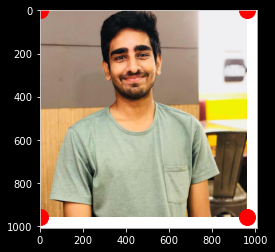

In [34]:
# need to reverse BGR to RGB because diff btw cv2 and plt
plt.imshow(image_source[...,::-1])
for x, y in four_corners_source:
    plt.plot(x, y, "ro", markersize=16)

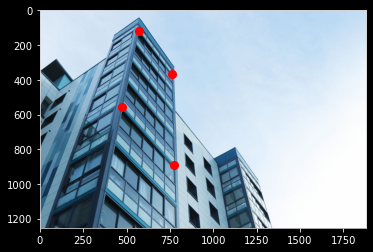

In [35]:
plt.imshow(image_destination[...,::-1])
for x, y in four_corners_destination:
    plt.plot(x, y, "ro", markersize=8)

Next, we try to find the homography the will map btw the two planes on which lie our rectangles.

```
findHomography(srcPoints, dstPoints[, method[, ransacReprojThreshold[, mask[, maxIters[, confidence]]]]]) -> retval, mask
```
@brief Finds a perspective transformation between two planes.

@param srcPoints Coordinates of the points in the original plane, a matrix of the type CV_32FC2
or vector\<Point2f\> .

@param dstPoints Coordinates of the points in the target plane, a matrix of the type CV_32FC2 or
a vector\<Point2f\> .

@param method Method used to compute a homography matrix. The following methods are possible:

-   **0** - a regular method using all the points, i.e., the least squares method
-   **RANSAC** - RANSAC-based robust method
-   **LMEDS** - Least-Median robust method
-   **RHO** - PROSAC-based robust method

@param ransacReprojThreshold Maximum allowed reprojection error to treat a point pair as an inlier
(used in the RANSAC and RHO methods only). That is, if
$$\| \texttt{dstPoints} _i -  \texttt{convertPointsHomogeneous} ( \texttt{H} * \texttt{srcPoints} _i) \|_2  >  \texttt{ransacReprojThreshold}$$
then the point $i$ is considered as an outlier. If srcPoints and dstPoints are measured in pixels,
it usually makes sense to set this parameter somewhere in the range of 1 to 10.

@param mask Optional output mask set by a robust method ( RANSAC or LMEDS ). Note that the input
mask values are ignored.

@param maxIters The maximum number of RANSAC iterations.

@param confidence Confidence level, between 0 and 1.

The function finds and returns the perspective transformation $H$ between the source and the
destination planes:

$$s_i  \vecthree{x'_i}{y'_i}{1} \sim H  \vecthree{x_i}{y_i}{1}$$

so that the back-projection error

$$\sum _i \left ( x'_i- \frac{h_{11} x_i + h_{12} y_i + h_{13}}{h_{31} x_i + h_{32} y_i + h_{33}} \right )^2+ \left ( y'_i- \frac{h_{21} x_i + h_{22} y_i + h_{23}}{h_{31} x_i + h_{32} y_i + h_{33}} \right )^2$$

is minimized. If the parameter method is set to the default value 0, the function uses all the point
pairs to compute an initial homography estimate with a simple least-squares scheme.

However, if not all of the point pairs ( $srcPoints_i$, $dstPoints_i$ ) fit the rigid perspective
transformation (that is, there are some outliers), this initial estimate will be poor. In this case,
you can use one of the three robust methods. The methods RANSAC, LMeDS and RHO try many different
random subsets of the corresponding point pairs (of four pairs each, collinear pairs are discarded), estimate the homography matrix
using this subset and a simple least-squares algorithm, and then compute the quality/goodness of the
computed homography (which is the number of inliers for RANSAC or the least median re-projection error for
LMeDS). The best subset is then used to produce the initial estimate of the homography matrix and
the mask of inliers/outliers.

Regardless of the method, robust or not, the computed homography matrix is refined further (using
inliers only in case of a robust method) with the Levenberg-Marquardt method to reduce the
re-projection error even more.

The methods RANSAC and RHO can handle practically any ratio of outliers but need a threshold to
distinguish inliers from outliers. The method LMeDS does not need any threshold but it works
correctly only when there are more than 50% of inliers. Finally, if there are no outliers and the
noise is rather small, use the default method (method=0).

The function is used to find initial intrinsic and extrinsic matrices. Homography matrix is
determined up to a scale. Thus, it is normalized so that $h_{33}=1$. Note that whenever an $H$ matrix
cannot be estimated, an empty one will be returned.

@sa
getAffineTransform, estimateAffine2D, estimateAffinePartial2D, getPerspectiveTransform, warpPerspective,
perspectiveTransform

**(?)** It says
> a matrix of the type `CV_32FC2` or `vector<Point2f>` for `srcPoints` and `dstPoints`

So can our lists `four_corners_destination` and `four_corners_source`  do the job or we have to convert them into ndarrays of dtype float32?

**(?)** The `5.0` is which one of the following?

- `ransacReprojThreshold`
- `mask`
- `maxIters`
- `confidence`

In [36]:
four_corners_source_float32 = np.array(four_corners_source, dtype=np.float32)
four_corners_destination_float32 = np.array(four_corners_destination, dtype=np.float32)

**(?)** The above conversion into ndarray: Discuss about copy and view and efficiency.

In [37]:
H, mask = cv2.findHomography(
    four_corners_source_float32,
    four_corners_destination_float32,
    cv2.RANSAC,
    5.0)
mask

array([[1],
       [1],
       [1],
       [1]], dtype=uint8)

In [38]:
H

array([[ 2.51646434e-01, -2.83446725e-01,  5.71000000e+02],
       [ 2.83571072e-01,  2.44103410e-01,  1.17000000e+02],
       [ 6.91444888e-05, -3.83432117e-04,  1.00000000e+00]])

Note that

01. `H` is of shape `(3, 3)`
02. `cv2.findHomography` is to be used with `cv2.warpPerspective` here


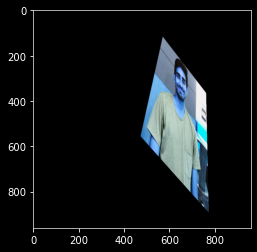

In [39]:
image_key = cv2.warpPerspective(image_source, H, (w_source, h_source))
plt.imshow(image_key);

In [40]:
image_key.shape

(960, 960, 3)

In [41]:
image_source.shape, image_destination.shape

((960, 960, 3), (1253, 1880, 3))

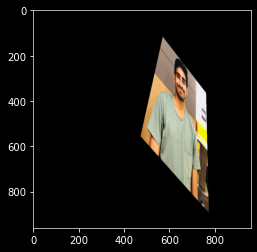

In [42]:
plt.imshow(image_key[..., ::-1]);

### Sth Wrong...
So, **the shape is a little weird**, because we should later on put this `image_transformed` on `image_destination`, and as such, their shapes should be identical.

I guess we have just given `cv2.warpPerspective()` wrong `(w, h)`. Let's try and correct that part to see what it gives.


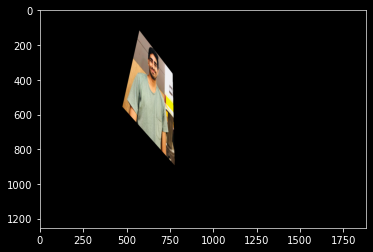

In [43]:
image_key = cv2.warpPerspective(image_source, H, (w_destination, h_destination))
plt.imshow(image_key[..., ::-1]);

<s>**ah, and btw**, `(w, h)` should probably have been `(h, w)` instead.</s>

Ok, looks more likely now.

**(?)** Write your own function (of inputs `H`, `image_source` and `(h_destination, w_destination)`) which manages to do the same thing as `cv2.warpPerspective()` 

## Make A Hole in `image_destination`
This so that we can insert the key `image_key` to form the final result.

In [44]:
help(cv2.fillConvexPoly)

Help on built-in function fillConvexPoly:

fillConvexPoly(...)
    fillConvexPoly(img, points, color[, lineType[, shift]]) -> img
    .   @brief Fills a convex polygon.
    .   
    .   The function cv::fillConvexPoly draws a filled convex polygon. This function is much faster than the
    .   function #fillPoly . It can fill not only convex polygons but any monotonic polygon without
    .   self-intersections, that is, a polygon whose contour intersects every horizontal line (scan line)
    .   twice at the most (though, its top-most and/or the bottom edge could be horizontal).
    .   
    .   @param img Image.
    .   @param points Polygon vertices.
    .   @param color Polygon color.
    .   @param lineType Type of the polygon boundaries. See #LineTypes
    .   @param shift Number of fractional bits in the vertex coordinates.



- `cv2.fillConvexPoly()` will change `img` **in-place**

In [45]:
image_key.dtype

dtype('uint8')

In [46]:
help(np.full)

Help on function full in module numpy:

full(shape, fill_value, dtype=None, order='C', *, like=None)
    Return a new array of given shape and type, filled with `fill_value`.
    
    Parameters
    ----------
    shape : int or sequence of ints
        Shape of the new array, e.g., ``(2, 3)`` or ``2``.
    fill_value : scalar or array_like
        Fill value.
    dtype : data-type, optional
        The desired data-type for the array  The default, None, means
         `np.array(fill_value).dtype`.
    order : {'C', 'F'}, optional
        Whether to store multidimensional data in C- or Fortran-contiguous
        (row- or column-wise) order in memory.
    like : array_like
        Reference object to allow the creation of arrays which are not
        NumPy arrays. If an array-like passed in as ``like`` supports
        the ``__array_function__`` protocol, the result will be defined
        by it. In this case, it ensures the creation of an array object
        compatible with that passe

In [48]:
np.int16

numpy.int16

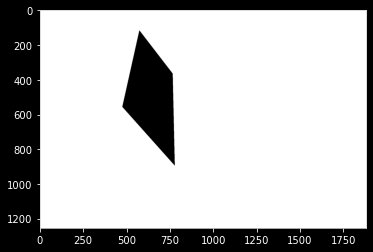

In [51]:
mask = np.full(shape=image_destination.shape, fill_value=255, dtype=np.uint8)
four_corners_destination_int32 = np.array(four_corners_destination, dtype=np.int32)
cv2.fillConvexPoly(mask, four_corners_destination_int32, 0)
plt.imshow(mask[...,::-1]);

In [52]:
help(cv2.bitwise_and)

Help on built-in function bitwise_and:

bitwise_and(...)
    bitwise_and(src1, src2[, dst[, mask]]) -> dst
    .   @brief computes bitwise conjunction of the two arrays (dst = src1 & src2)
    .   Calculates the per-element bit-wise conjunction of two arrays or an
    .   array and a scalar.
    .   
    .   The function cv::bitwise_and calculates the per-element bit-wise logical conjunction for:
    .   *   Two arrays when src1 and src2 have the same size:
    .   \f[\texttt{dst} (I) =  \texttt{src1} (I)  \wedge \texttt{src2} (I) \quad \texttt{if mask} (I) \ne0\f]
    .   *   An array and a scalar when src2 is constructed from Scalar or has
    .   the same number of elements as `src1.channels()`:
    .   \f[\texttt{dst} (I) =  \texttt{src1} (I)  \wedge \texttt{src2} \quad \texttt{if mask} (I) \ne0\f]
    .   *   A scalar and an array when src1 is constructed from Scalar or has
    .   the same number of elements as `src2.channels()`:
    .   \f[\texttt{dst} (I) =  \texttt{src1}  \wed

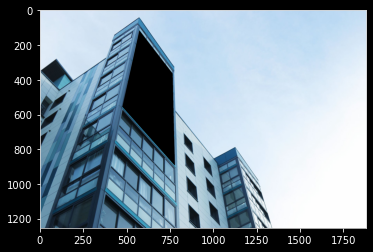

In [53]:
image_hole = cv2.bitwise_and(image_destination, mask)
show(image_hole)

**N.B.** The functions `cv2.bitwise_and()` and `cv2.bitwise_or()` are

- Their inputs are two images of the same shape.
- Their return value will be another image of that same shape
- They do element-wise operations, where the operation is either `&` or `|` on the corresponding two elements of the images (That's why these images have to be of type integers)

To get the final result,

- either you just add `image_hole + image_key`
- or fancier, you can use `cv2.bitwise_or()`

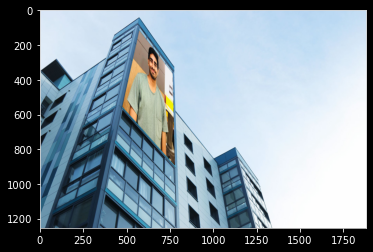

In [54]:
show(image_hole + image_key)

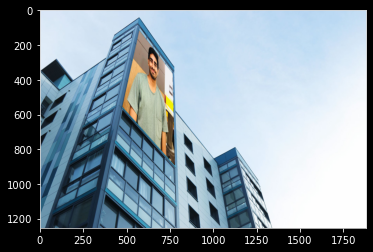

In [55]:
show(cv2.bitwise_or(image_hole, image_key))